In [ ]:
!pip install transformers
!pip install tensorly
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import MarianMTModel, MarianTokenizer
from tensorly.decomposition import parafac
from tensorly.decomposition import CP
from tensorly.cp_tensor import cp_to_tensor
import torchvision.transforms as transforms
import torchvision
import tensorly as tl
tl.set_backend('pytorch')
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification
from tqdm import tqdm
import time
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CPCompressedLinear(nn.Module):
    def __init__(self, original_weight, rank=2, bias=None):
        super(CPCompressedLinear, self).__init__()
        self.input_dim, self.output_dim = original_weight.shape

        self.cp_cores = parafac(original_weight, rank=rank)

        self.bias = nn.Parameter(bias) if bias is not None else None

    def reconstruct_weights(self):
        return cp_to_tensor(self.cp_cores)

    def forward(self, x):
        weights = self.reconstruct_weights()
        output = x @ weights.T
        if self.bias is not None:
            output += self.bias
        return output

In [6]:
def cp_compress(model, rank=2):
    for name, layer in model.named_modules():
        if "classifier" in name:
            continue

        if isinstance(layer, nn.Linear):
            bias = layer.bias.data if layer.bias is not None else None

            with torch.no_grad():
                original_weight = layer.weight.data
                new_layer = CPCompressedLinear(
                    original_weight=original_weight,
                    bias=bias,
                    rank=rank
                )
                parent_module, layer_name = _get_parent_module(model, name)
                setattr(parent_module, layer_name, new_layer)
    return model

def _get_parent_module(model, module_name):
    parts = module_name.split(".")
    parent = model
    for part in parts[:-1]:
        parent = getattr(parent, part)
    return parent, parts[-1]

In [48]:
dataset = CIFAR10(root='./data', train=False, download=True)
dataloader = DataLoader(dataset, batch_size=400, shuffle=False, num_workers=2)

feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')

Files already downloaded and verified


In [9]:
tensor_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [49]:
def evaluate(model):
  with torch.no_grad():
    correct = 0
    c = 0
    for image, label in dataset:
      if c == 100:
        break
      features = feature_extractor(image, return_tensors='pt')['pixel_values'].to(device)
      start_time = time.time()
      predictions = model(features).logits.argmax(dim=1)
      correct += (predictions == label).sum()
      end_time = time.time()
      time1 = end_time - start_time
      c += 1
    return (correct / 100, time1)

In [50]:
evaluations = []
ranks = [10, 50, 100, 200, 400, 500, 600, 700]

In [51]:
from inspect import EndOfBlock
for rank in tqdm([10, 50, 100, 200, 400, 500, 600, 700]):
  model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
  model.to(device)
  compressed = cp_compress(model, rank=rank)
  compressed.to(device)
  evaluations.append(evaluate(compressed))

100%|██████████| 8/8 [02:23<00:00, 17.90s/it]


In [17]:
original = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
original.to(device)

In [52]:
evaluations

[(tensor(0.0800, device='cuda:0'), 0.021479368209838867),
 (tensor(0.1200, device='cuda:0'), 0.013134002685546875),
 (tensor(0.1200, device='cuda:0'), 0.012869119644165039),
 (tensor(0.6000, device='cuda:0'), 0.01275944709777832),
 (tensor(0.9500, device='cuda:0'), 0.013398885726928711),
 (tensor(0.9700, device='cuda:0'), 0.01322627067565918),
 (tensor(0.9900, device='cuda:0'), 0.015031099319458008),
 (tensor(0.9900, device='cuda:0'), 0.023205041885375977)]

In [72]:
accs = []
times = []

for i in range(len(evaluations)):
  accs.append(evaluations[i][0].detach().cpu().numpy().item())
  times.append(evaluations[i][1])

<Axes: >

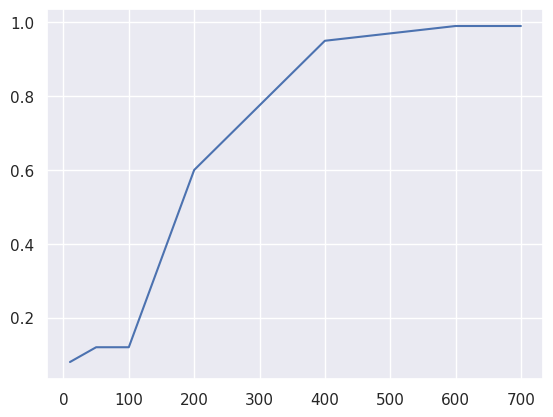

In [74]:
sns.set_theme(style='darkgrid')
sns.lineplot(x=ranks, y=accs)

<Axes: >

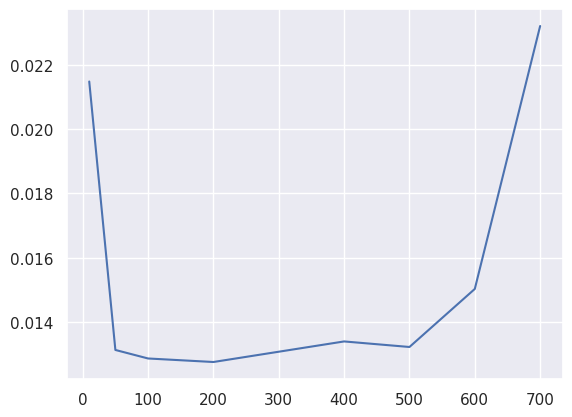

In [75]:
sns.lineplot(x=ranks, y=times)